In [1]:
!ls

cnn1.png	 성북구.csv		  gru1.png
CNN-Copy1.ipynb  화랑로.csv		  GRU-Copy1.ipynb
CNN_GRU.h5	 은평구.csv		  GRU.h5
CNN+GRU.ipynb	 성동구.csv		  GRU.ipynb
CNN.h5		 마포구.csv		  hybrid1.png
CNN.ipynb	 노원구.csv		  hybrid2.png
CNN_LSTM.h5	 송파구.csv		  LONG
CNN+LSTM.ipynb	 서초구.csv		  lstm1.png
종로.csv	 강서구.csv		  LSTM.h5
중구.csv	 신촌로.csv		  LSTM.ipynb
구로구.csv	 용산구.csv		  Model comparsion.ipynb
금천구.csv	 동작대로 중앙차로.csv	  PM_Seoul.html
양천구.csv	 서대문구.csv		  Seoul_cnn_checkpoint.hdf5
동작구.csv	 영등포구.csv		  Seoul_cnn_gru_checkpoint.hdf5
중랑구.csv	 영등포로.csv		  Seoul_cnn_gru_logs
도봉구.csv	 도산대로.csv		  Seoulcnn_logs
광진구.csv	 한강대로.csv		  Seoul_cnn_lstm_checkpoint.hdf5
강동구.csv	 공항대로.csv		  Seoul_cnn_lstm_logs
관악구.csv	 청계천로.csv		  Seoul_gru_checkpoint.hdf5
강남구.csv	 강남대로.csv		  Seoul_gru_logs
강북구.csv	 강변북로.csv		  Seoul_lstm_checkpoint.hdf5
종로구.csv	 천호대로.csv		  Seoul_lstm_logs
정릉로.csv	 동대문구.csv		  SHORT
홍릉로.csv	 data_visual-Copy2.ipynb


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd

df=read_csv('강남구.csv', header=0, dtype=({'date':str}))
df.drop(['location'], axis=1, inplace=True)

col_list=df.columns
for each in col_list:
    df[each].fillna(0, inplace=True)

df['datetime']=pd.to_datetime(df['date'])+pd.TimedeltaIndex(df['time'], unit='H')
df.drop(['date', 'time'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)

df['windx']=df['wind_speed']*np.cos(df['wind_direction'])
df['windy']=-df['wind_speed']*np.sin(df['wind_direction'])
df.drop(['wind_direction', 'wind_speed'], axis=1, inplace=True)

#some extrme maybe dust which condider not the real concentration
#change to average of the column
df.loc[df['pm10']>400, ['pm10']]=df.pm10.mean()
df.loc[df['pm25']>180, ['pm25']]=df.pm25.mean()
df.loc[df['temperature']>45, ['temperature']]=df.temperature.mean()
df.loc[df['temperature']<-25, ['temperature']]=df.temperature.mean()
df.loc[df['rain']<0, ['rain']]=df.rain.mean()

In [4]:
from pytz import all_timezones
import pytz

utc_seoul=pytz.timezone('Asia/Seoul')
df.index=df.index.tz_localize(tz='Asia/Seoul')

In [5]:
df.columns

Index(['pm10', 'pm25', 'temperature', 'sky_condition', 'rain', 'humidity',
       'rain_condition', 'windx', 'windy'],
      dtype='object')

In [6]:
target_names=['pm10','pm25']

#station defined as the number of observation stations in each cities
stations=1
shift_days=1
#cause have 39 sub area in Seoul of this dataset
shift_steps=shift_days*stations

df_targets=df[target_names].shift(-shift_steps)

x_data=df.values[0:-shift_steps:]
y_data=df_targets.values[:-shift_steps]
print(x_data.shape)
print(y_data.shape)

#seperate the data set
num_data = len(x_data)
train_split = 0.7
num_train = int(train_split * num_data)
num_val = int(((1-train_split)*0.80)*num_data)
num_test = num_data-num_train-num_val

#in case some NaN exist in the numpy array
loc=np.isnan(x_data)
x_data[loc]=0

#seperate data 
#input signals for training and test
x_train = x_data[:num_train,0:]
x_val = x_data[num_train:num_train+num_val,0:]
x_test = x_data[num_train+num_val:,0:]
print("seperated x dataset:" ,x_train.shape,x_val.shape, x_test.shape)

#output signals for trainnig and test
y_train = y_data[0:num_train]
y_val = y_data[num_train:num_train+num_val]
y_test = y_data[num_train+num_val:]
print("seperated y dataset:" ,y_train.shape, y_val.shape, y_test.shape)

print("traning days:",num_train//stations//24)
print("validation days:", num_val//stations//24)
print('test days:', num_test//stations//24)

#### import numpy as np
from sklearn.preprocessing import MinMaxScaler

#scale data 
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.fit_transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.fit_transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

(34895, 9)
(34895, 2)
seperated x dataset: (24426, 9) (8374, 9) (2095, 9)
seperated y dataset: (24426, 2) (8374, 2) (2095, 2)
traning days: 1017
validation days: 348
test days: 87
Min: -16.799999
Max: 369.0


In [7]:
#generate batch of shorter sequences picked at random from the training data

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals. 
        x_shape = (batch_size, sequence_length, x_train_scaled.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_train_scaled.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length) 
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [8]:
#depended on your GPU
batch_size = 256
#one day 24*39
sequence_length = 24*stations

generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 24, 9)
(256, 24, 2)


In [9]:
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

test_data = (np.expand_dims(x_test_scaled, axis=0),
            np.expand_dims(y_test_scaled, axis=0))

In [10]:
#normalization 
#mean = float_data[:].mean(axis=0)
#float_data -= mean
#std = float_data[:].std(axis=0)
#float_data /= std

In [11]:
x_train_scaled.shape

(24426, 9)

In [12]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, InputLayer, Reshape, LSTM
from keras.layers import LeakyReLU, TimeDistributed, BatchNormalization
from keras.optimizers import RMSprop

model = Sequential()
#input shape for conv1D is (batch, steps, features)

model.add(Conv1D(128, 24, padding='same', activation='relu', input_shape=(None,x_train.shape[-1])))
#model.add(LeakyReLU(alpha=0.1))
#model.add(MaxPooling1D(2))
#model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(32, activation='linear'))
model.add(Dense(2, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         27776     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_2 (Dense)              (None, None, 2)           66        
Total params: 79,330
Trainable params: 79,330
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.optimizers import RMSprop,adam
from keras import losses
model.compile(loss=losses.mean_squared_error, optimizer=adam(lr=0.01), metrics=['acc'])


In [14]:
#create the callback to save checkpoints and log the progress to TensorBoard
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

path_checkpoint='Seoul_cnn_lstm_checkpoint.hdf5'
callback_checkpoint=ModelCheckpoint(filepath=path_checkpoint,
                                    monitor='val_loss',
                                    verbose=1,save_weights_only=True,save_best_only=True)



callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./Seoul_cnn_lstm_logs/',
                                   histogram_freq=0,
                                   write_graph=True)
# callback reduces the learning-rate for the optimizer 
#if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). 
#The learning-rate will be reduced
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       mode='auto',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)

#stop to use the ReduceLROnPlateau(), cause problem like'Attempting to use uninitialized value Adam/lr'

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             #callback_reduce_lr
            ]

In [16]:
%%time
history= model.fit_generator(generator=generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0170 - acc: 0.5812 - val_loss: 0.0031 - val_acc: 0.7934

Epoch 00001: val_loss improved from inf to 0.00306, saving model to Seoul_cnn_lstm_checkpoint.hdf5
Epoch 2/50
100/100 [==============================] - 3s 31ms/step - loss: 0.0018 - acc: 0.6784 - val_loss: 0.0010 - val_acc: 0.8481

Epoch 00002: val_loss improved from 0.00306 to 0.00101, saving model to Seoul_cnn_lstm_checkpoint.hdf5
Epoch 3/50
100/100 [==============================] - 3s 31ms/step - loss: 0.0012 - acc: 0.6985 - val_loss: 6.9056e-04 - val_acc: 0.8605

Epoch 00003: val_loss improved from 0.00101 to 0.00069, saving model to Seoul_cnn_lstm_checkpoint.hdf5
Epoch 4/50
100/100 [==============================] - 3s 31ms/step - loss: 7.1898e-04 - acc: 0.7877 - val_loss: 8.9369e-04 - val_acc: 0.8692

Epoch 00004: val_loss did not improve from 0.00069
Epoch 5/50
100/100 [==============================] - 3s 31ms/step - loss: 5.7517e-04 - acc: 0.8

100/100 [==============================] - 3s 31ms/step - loss: 1.3938e-04 - acc: 0.9118 - val_loss: 1.2989e-05 - val_acc: 0.9881

Epoch 00039: val_loss did not improve from 0.00001
Epoch 40/50
100/100 [==============================] - 3s 31ms/step - loss: 9.9502e-05 - acc: 0.9157 - val_loss: 9.0050e-05 - val_acc: 0.8531

Epoch 00040: val_loss did not improve from 0.00001
Epoch 41/50
100/100 [==============================] - 3s 31ms/step - loss: 1.2646e-04 - acc: 0.9176 - val_loss: 1.1983e-05 - val_acc: 0.9716

Epoch 00041: val_loss did not improve from 0.00001
Epoch 00041: early stopping
CPU times: user 2min 29s, sys: 5.55 s, total: 2min 35s
Wall time: 2min 8s


In [17]:
test_loss, test_acc = model.evaluate(test_data[0], test_data[1])
print('test acc:', test_acc)

1/1 [==============================] - 0s 332ms/step
test acc: 0.9670644402503967


In [18]:
print(model.history.history.keys())

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


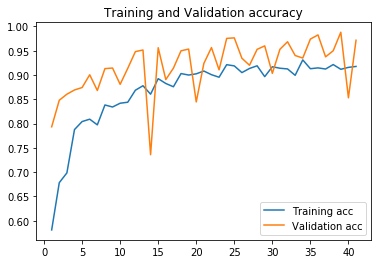

<Figure size 432x288 with 0 Axes>

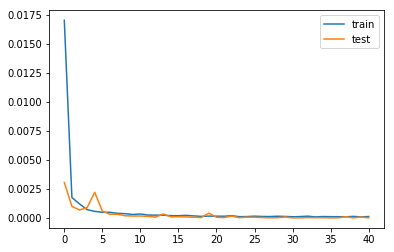

In [20]:
#plot the  traning and validation acc
import matplotlib.pyplot as plt

acc=model.history.history['acc']
val_acc=model.history.history['val_acc']
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

#plt.figure(dpi=800)
plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc , label='Validation acc')
plt.title('Training and Validation accuracy')

plt.legend()
plt.figure()
plt.show()

#plt.figure(dpi=800)
plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.show()

In [21]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

#test data include x_test_scaled and y_test_scaled
y_pred=model.predict(test_data[0])
y_pred_rescaled=y_scaler.inverse_transform(y_pred[0])

y_cap = y_scaler.inverse_transform(test_data[1][0])
                                   
mae_pm10=mean_absolute_error(y_cap[:, 0],y_pred_rescaled[:, 0])
mae_pm25=mean_absolute_error(y_cap[:, 1],y_pred_rescaled[:, 1])

rmse_pm10=sqrt(mean_squared_error(y_cap[:, 0], y_pred_rescaled[:, 0]))
rmse_pm25=sqrt(mean_squared_error(y_cap[:, 1], y_pred_rescaled[:, 1]))
print('mae_pm10:\t',mae_pm10)
print('mae_pm25:\t',mae_pm25)
print('rmse_pm10:\t',rmse_pm10)
print('rmse_pm25:\t',rmse_pm25)

mae_pm10:	 0.5559368447073889
mae_pm25:	 0.5416936347443335
rmse_pm10:	 0.9203149336773616
rmse_pm25:	 0.7576721666787949


In [22]:
#predict_on_batch(x_test_scaled)

#generate prediction
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

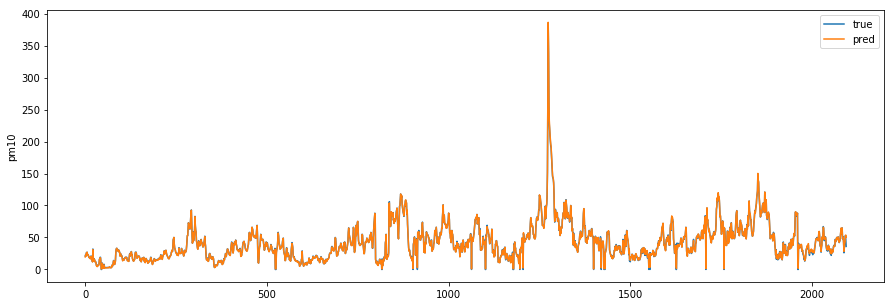

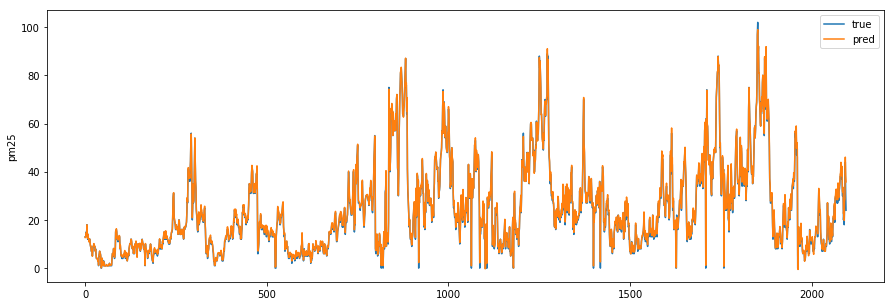

In [23]:
plot_comparison(start_idx=0, length=10000, train=False)

240
1/1 [==============================] - 0s 37ms/step
loss and acc: [3.827681666734861e-06, 0.9541666507720947]
(1, 240, 2)
rmse_pm10: 0.463
rmse_pm25: 0.320
mae_pm10:  0.386
mae_pm25:  0.257


/home/oslab/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/oslab/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/oslab/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


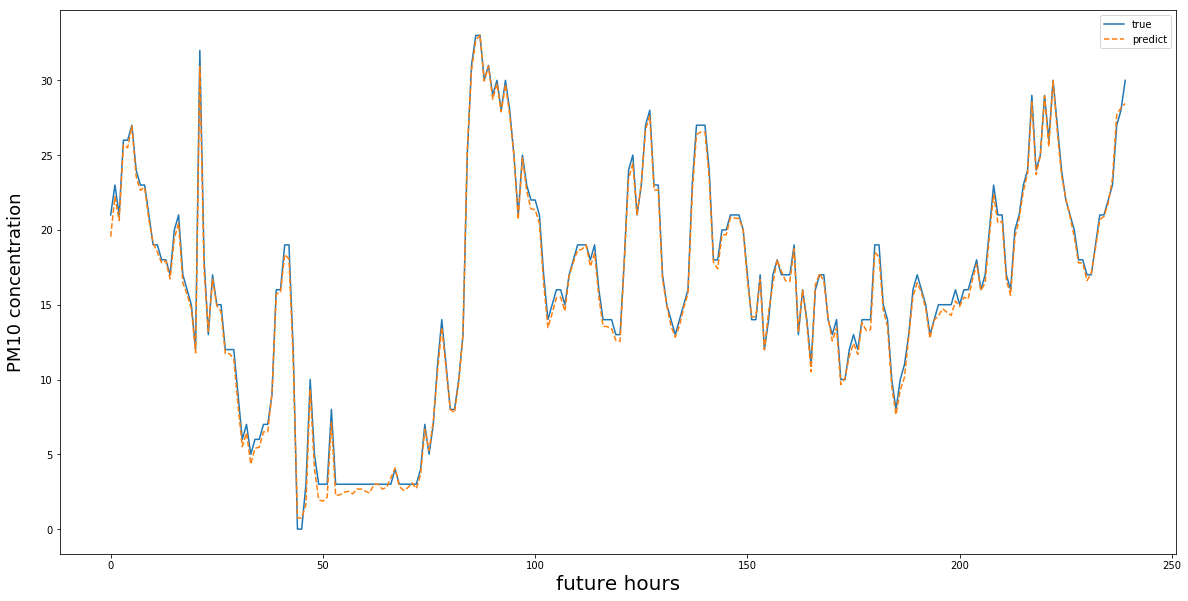

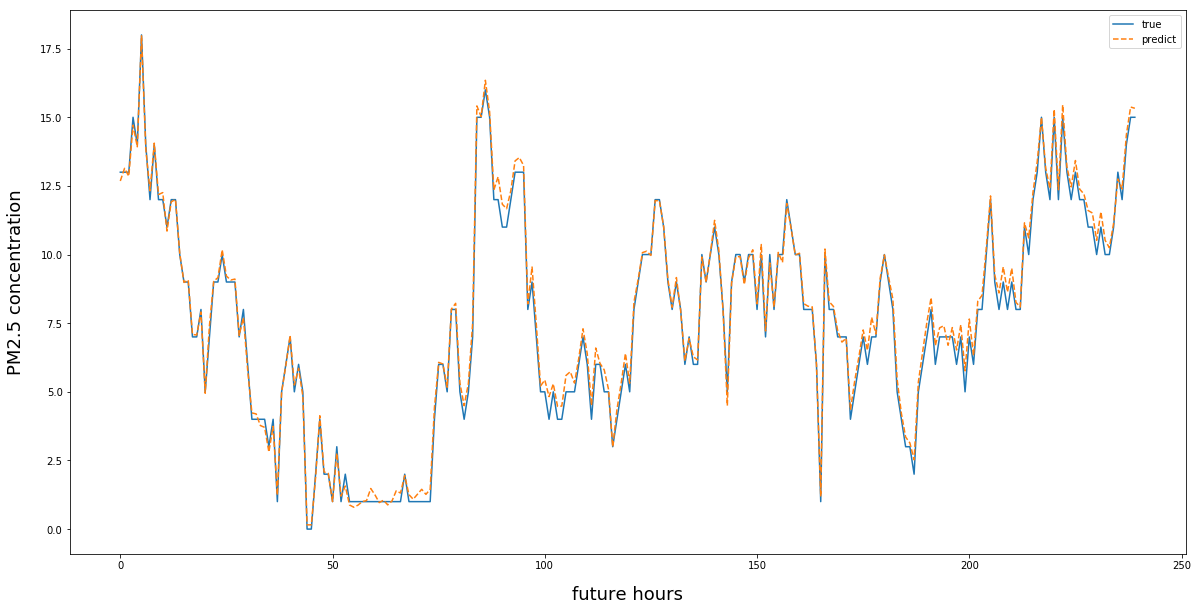

In [24]:
#get the different time length predicting result

day=10
temp_size=day*stations*24
print(temp_size)

temp_x=x_test_scaled[:temp_size]
temp_y=y_test_scaled[:temp_size]

new=model.evaluate(x=np.expand_dims(temp_x, axis=0), y=np.expand_dims(temp_y, axis=0))
print("loss and acc:", new)


test_temp_0=test_data[0][:,:temp_size,:]
test_temp_1=test_data[1][:,:temp_size,:]
print(test_temp_1.shape)

#calculate the predicting results
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

#caution! test data include x_test_scaled and y_test_scaled
yy_pred=model.predict(test_temp_0)

yy_pred_rescaled=y_scaler.inverse_transform(yy_pred[0])
yy_cap = y_scaler.inverse_transform(test_temp_1[0])
                                   
mae_pm10=mean_absolute_error(yy_cap[:, 0],yy_pred_rescaled[:, 0])
mae_pm25=mean_absolute_error(yy_cap[:, 1],yy_pred_rescaled[:, 1])

rmse_pm10=sqrt(mean_squared_error(yy_cap[:,0], yy_pred_rescaled[:,0]))
rmse_pm25=sqrt(mean_squared_error(yy_cap[:,1], yy_pred_rescaled[:,1]))

print('rmse_pm10: %.3f'%rmse_pm10)
print('rmse_pm25: %.3f'%rmse_pm25)
print('mae_pm10:  %.3f'%mae_pm10)
print('mae_pm25:  %.3f'%mae_pm25)

#draw the concentration trends in limited length of time
# combine the staions in the same city, use average  of stations to represent one time point 
#(combine the stations in same time to one time point )

sep_size=y_test.shape[0]//stations
y_test_avg=np.zeros((sep_size,2))
y_pred_rescaled_avg=np.zeros((sep_size,2))

for i in range(sep_size):
    y_test_avg[i, 0]=np.mean(yy_cap[i*stations:stations*(i+1),0])
    y_test_avg[i, 1]=np.mean(yy_cap[i*stations:stations*(i+1),1])
    y_pred_rescaled_avg[i, 0]=np.mean(yy_pred_rescaled[i*stations:stations*(i+1),0])
    y_pred_rescaled_avg[i, 1]=np.mean(yy_pred_rescaled[i*stations:stations*(i+1),1])


from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
plt.plot(y_test_avg[:24*day,0], label='true')
plt.plot(y_pred_rescaled_avg[:24*day,0], label='predict',linestyle='dashed')
plt.ylabel('PM10 concentration',size=18, labelpad=15)
plt.xlabel('future hours',size=20)
#p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
plt.legend()
plt.show()

pyplot.figure(figsize=(20,10))
plt.plot(y_test_avg[:24*day,1], label='true')
plt.plot(y_pred_rescaled_avg[:24*day,1], label='predict',linestyle='dashed')
plt.ylabel('PM2.5 concentration',size=18, labelpad=15)
plt.xlabel('future hours',size=18, labelpad=15)
#p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
plt.legend()
plt.show()

In [25]:
from keras.models import load_model
model.save('CNN_LSTM.h5')